# Ocean Parcels Visualisation
Code for plotting Ocean Parcels runs so that you dont have to re-run your simmulation every time

In [29]:
import xarray as xr
from matplotlib import pyplot as plt, animation
import numpy as np
from IPython.display import HTML

In [11]:
# Define paths
paths = {
    'coords': '/ocean/rbeutel/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/ocean/rbeutel/MEOPAR/grid/mesh_mask201702.nc',
    'out': './results',
}

In [15]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [16]:
outfile = paths['out']+'/becca_drifters20190601_20190606.nc' #need to type in filename here
ds = xr.open_dataset(outfile)
print(ds)

<xarray.Dataset>
Dimensions:     (obs: 121, traj: 1000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical


In [20]:
n = 1000   # number of particles
clon, clat = -123.541153, 48.224371

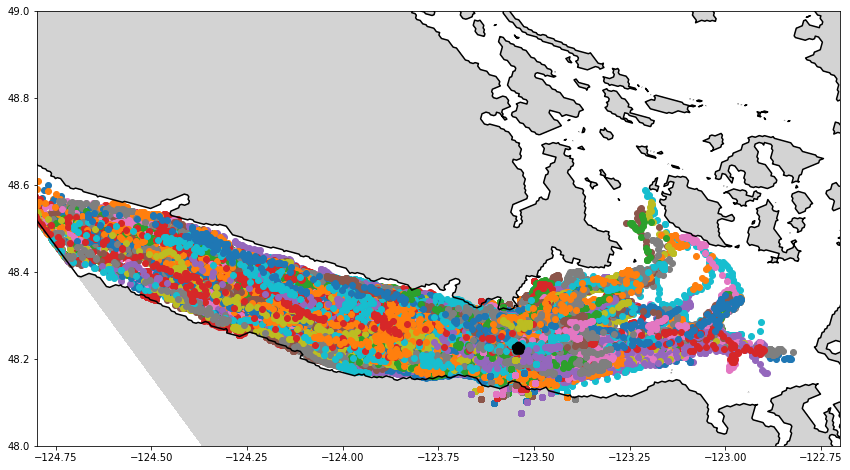

In [21]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
for traj in range(n):
    s = ax.scatter(ds.lon[traj, nmin:nmax], ds.lat[traj, nmin:nmax])
ax.scatter(clon,clat,c='k', marker='*', linewidths=8)

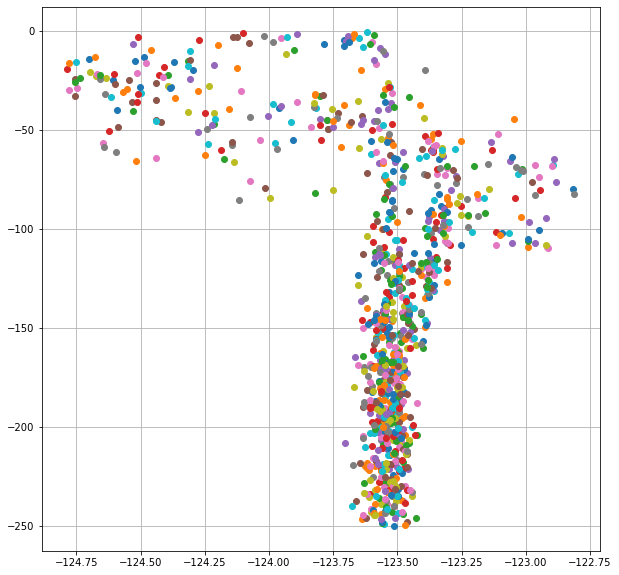

In [22]:
nmax = -1
fig, ax = plt.subplots(figsize=(10, 10))
for traj in range(n):
    ax.plot(ds.lon[traj, nmax], -ds.z[traj, nmax], 'o')
ax.grid()

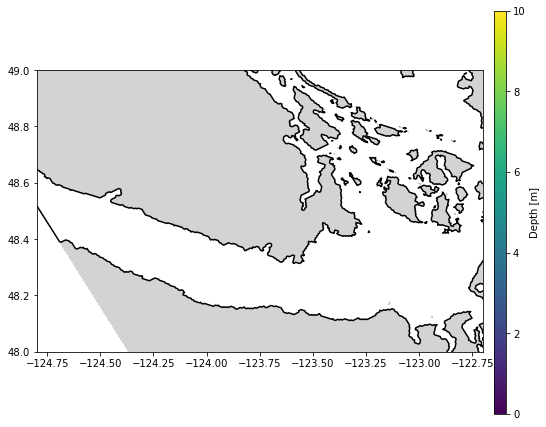

In [27]:
# Make initial figure
fig, ax = plt.subplots(figsize=(8, 8))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
l = ax.scatter([], [], s=50, c=[], vmin=0, vmax=10, edgecolor='k')
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
data = xr.open_dataset('results/becca_drifters20200601_20200602.nc')
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
#ax.set_title('NEMO_3D')
ax.set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l, cax=cax, label='Depth [m]')

# Init function
def init():
    t.set_text('')
    l.set_offsets(np.empty((0, 2)))
    l.set_array(np.empty(0))
    return l, t,

# Animate function
def animate(hour):
    tstamp = data.time[0, hour].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    l.set_offsets(np.vstack([data.lon[:, hour], data.lat[:, hour]]).T)
    l.set_array(data.z[:, hour])
    return l, t,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=73, interval=100, blit=True)

In [30]:
# Render animation
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [31]:
import ffmpeg

ModuleNotFoundError: No module named 'ffmpeg'